# 1 可视化整个模型中的输入输出，方便分析

In [1]:
#---------------------------------#
#  预备工作：
#  导入库
#  加载配置文件
#  加载模型，加载数据集
#---------------------------------#

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()
model = GraphModel(cfg)
test_dataset = GraphDataset(cfg,'Validation',True)
# checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
checkpoint = torch.load(r'experiments\checkpoints\bestScore(1.0)_epoch(86).pth')
model.load_state_dict(checkpoint["model"], strict=False)

raw_tra_graph,raw_det_graph,gt_matrix = test_dataset.__getitem__(950)

d:\anaconda3\envs\2torch1.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[Validation] Data-preprocess: 100%|██████████| 1/1 [00:08<00:00,  8.79s/dataset]
2024-12-10 21:14:29.103 | INFO     | utils.graphDataset:__init__:90 - [Validation] Total frame number : 4463


In [2]:

import sys
def get_size_KB(obj, seen=None):
    size = sys.getsizeof(obj)
    if seen is None:
        seen = set()
    obj_id = id(obj)
    if obj_id in seen:
        return 0
    # Mark as seen *before* entering recursion to gracefully handle
    # self-referential objects
    seen.add(obj_id)
    if isinstance(obj, dict):
        size += sum([get_size_KB(v, seen) for v in obj.values()])
        size += sum([get_size_KB(k, seen) for k in obj.keys()])
    elif hasattr(obj, '__dict__'):
        size += get_size_KB(obj.__dict__, seen)
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum([get_size_KB(i, seen) for i in obj])
    return size /1024

get_size_KB(test_dataset.dets_dict)

0.41747057777283914

## 1.1 轨迹图与检测图节点 原始像素可视化

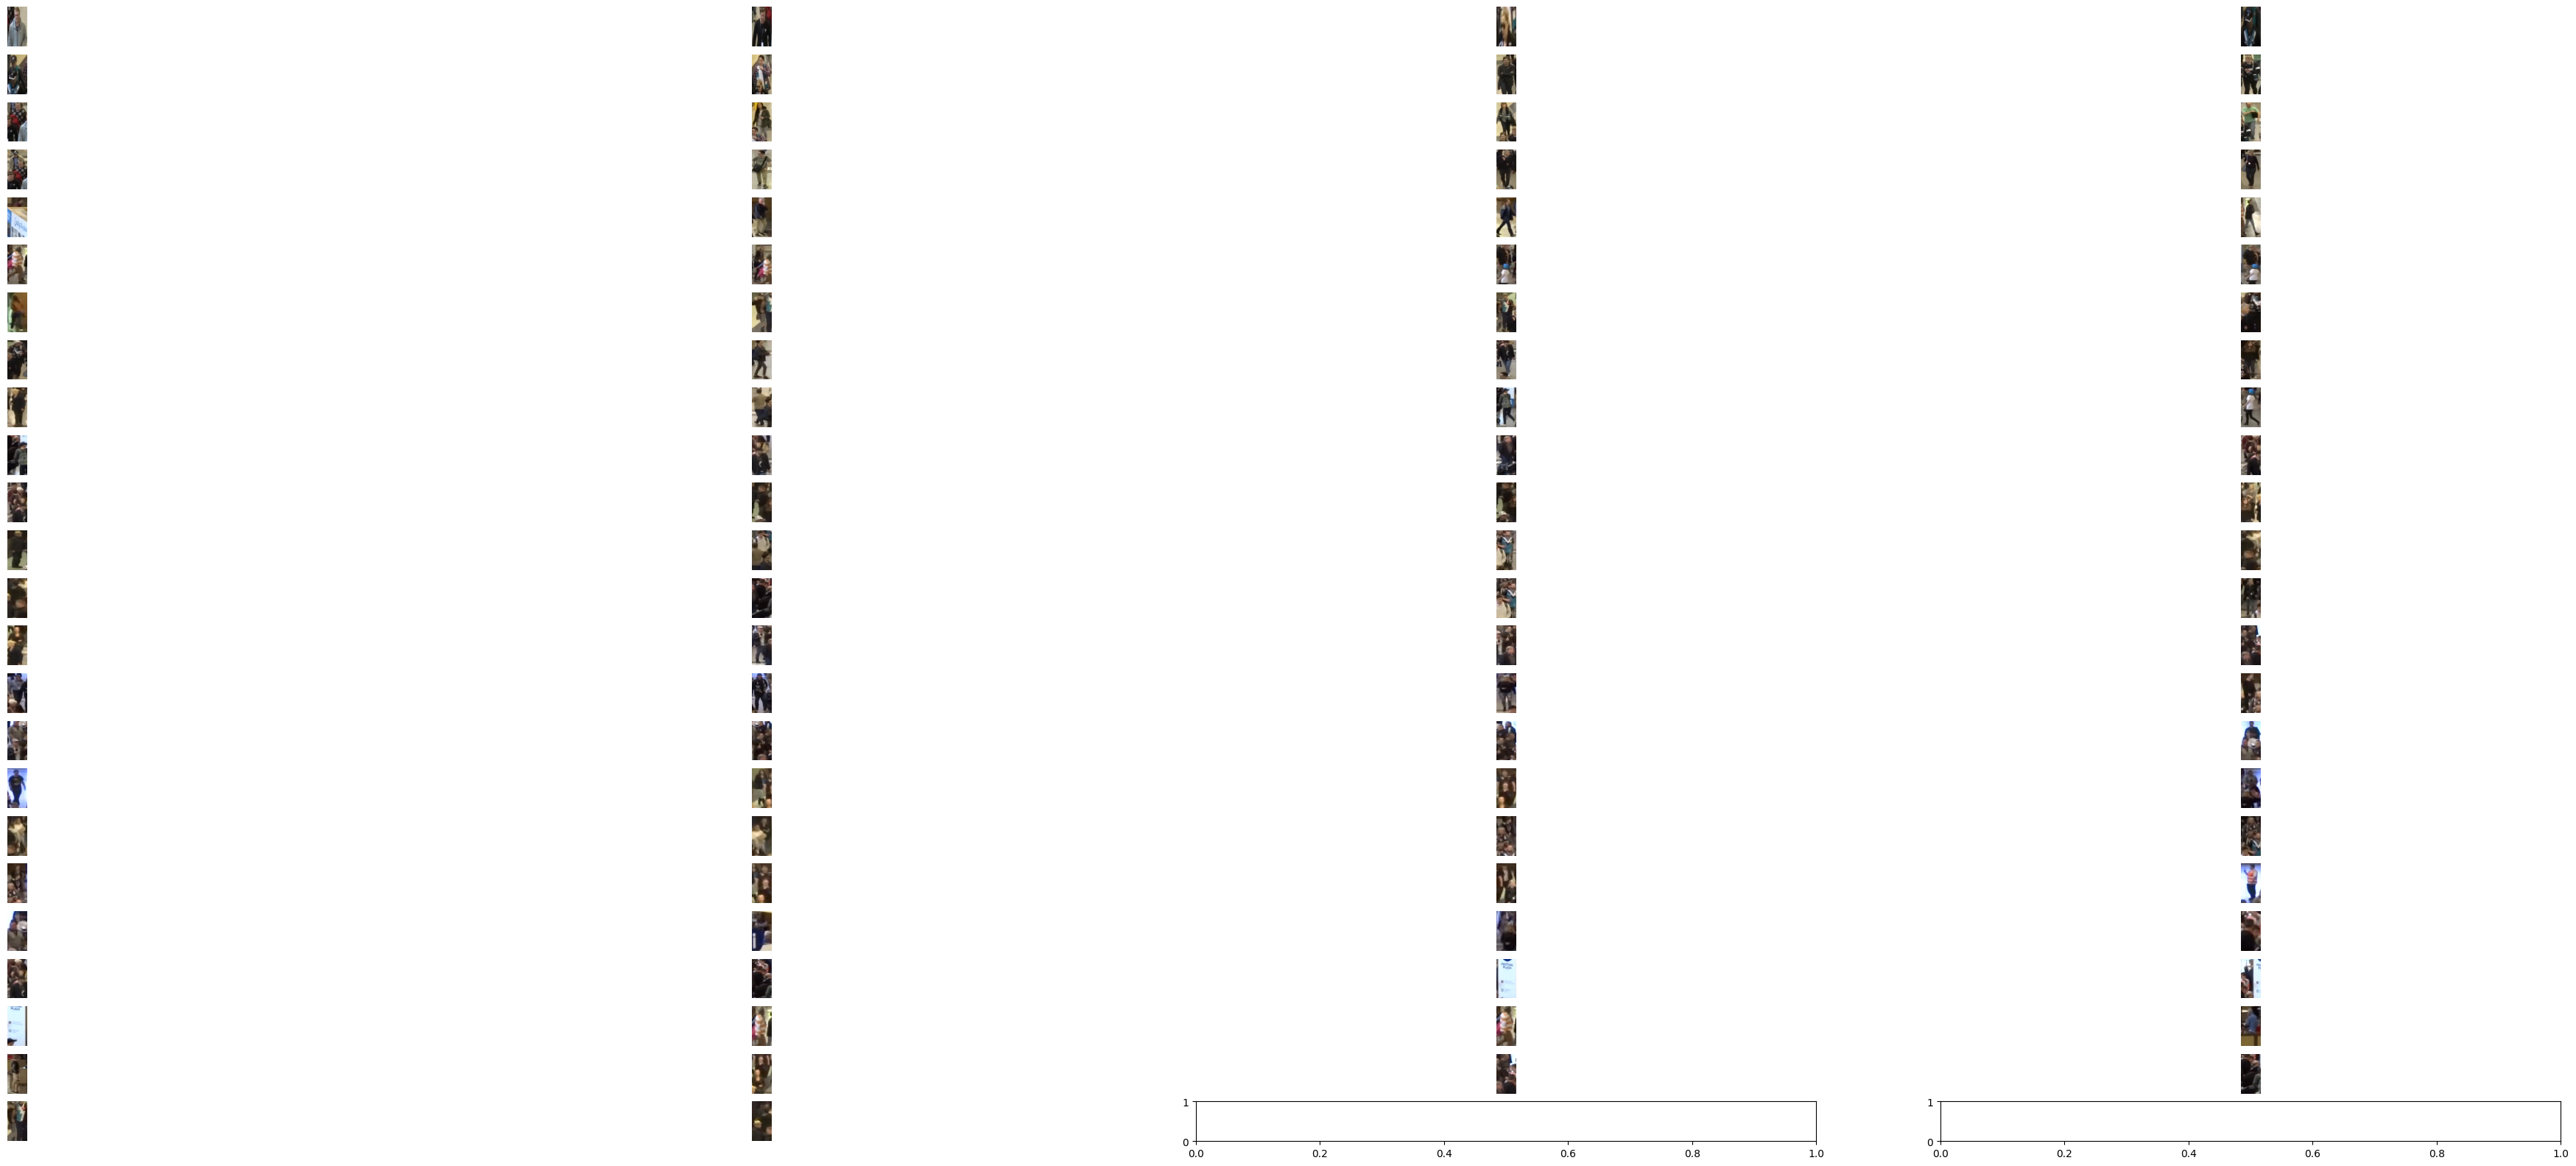

In [3]:
import math
from matplotlib import pyplot as plt
def scale_patch_to_0_1(patch):
    """将裁剪后的图像patch缩放到[0, 1]范围内"""
    patch_max = torch.max(patch)
    patch_min = torch.min(patch)
    patch = (patch - patch_min) / (patch_max - patch_min)  # 确保像素值在 [0, 1] 范围
    return patch 
# import torchvision.transforms.functional as F
tra_obj_ims = raw_tra_graph.x
num_tra    = tra_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 4)
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(tra_obj_ims[i])
    # print(patch.shape)
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

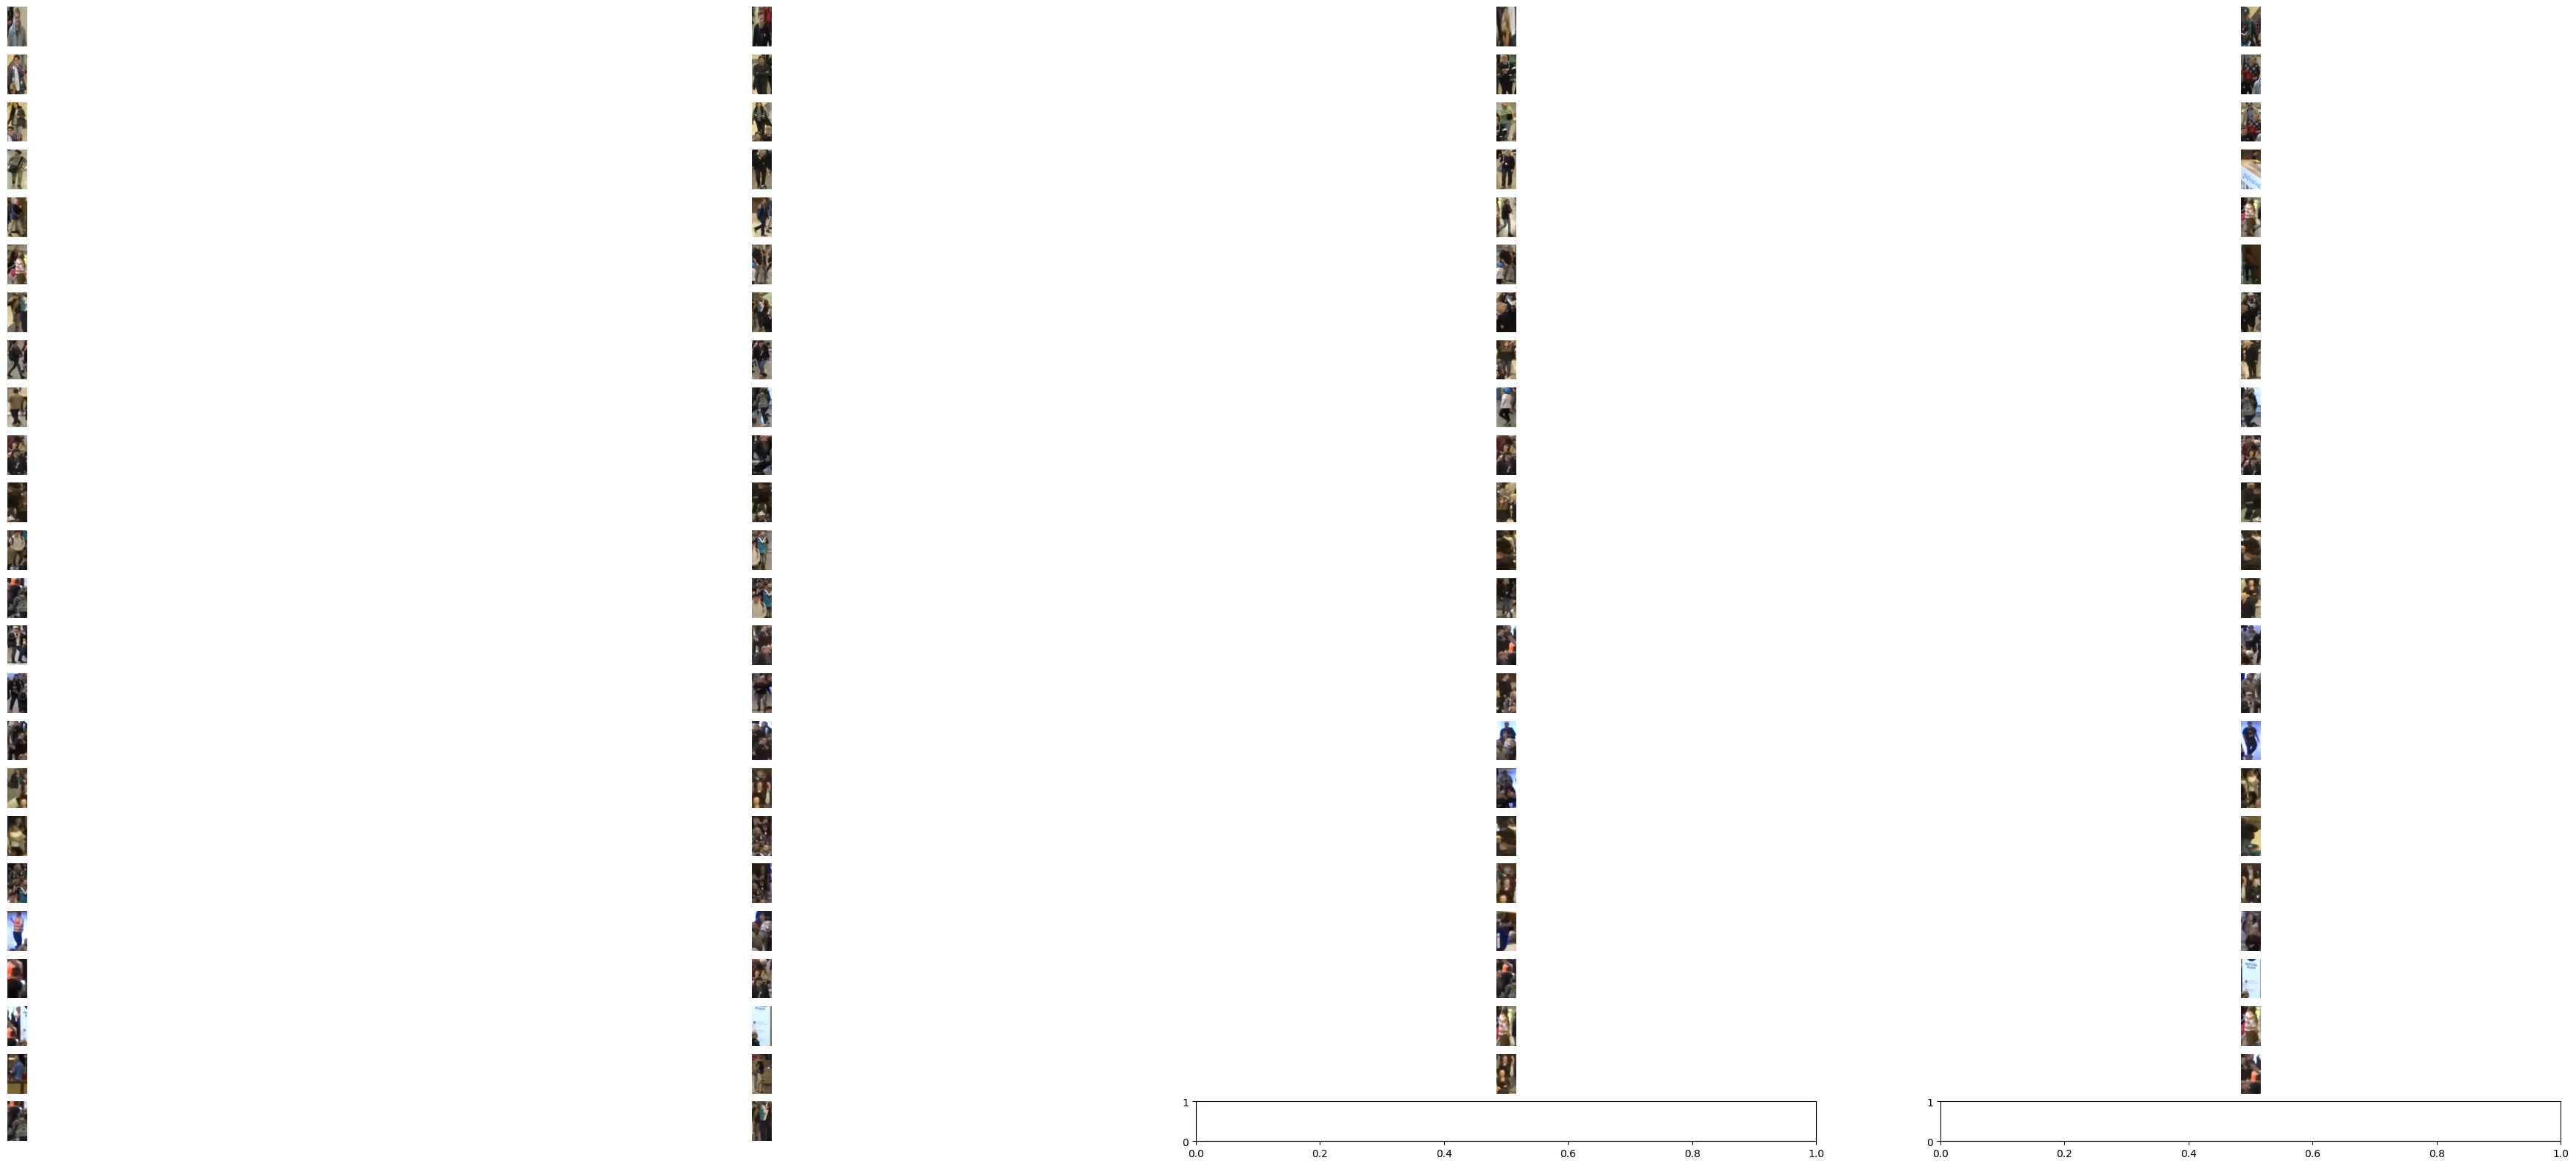

In [4]:
det_obj_ims = raw_det_graph.x
num_tra    = det_obj_ims.shape[0] 
num_rows = math.ceil(num_tra / 4)
fig, axs   = plt.subplots(num_rows, 4, figsize=(50, 20))
# # plt.imshow(tra_obj_im)

for i in range(num_tra):
    row = i //4
    col = i % 4
    patch = scale_patch_to_0_1(det_obj_ims[i])
    axs[row,col].imshow(patch.permute(1,2,0).numpy())
    axs[row,col].axis('off')
plt.show()

## 1.2 轨迹图与检测图经过Node Encoder之后的热力图

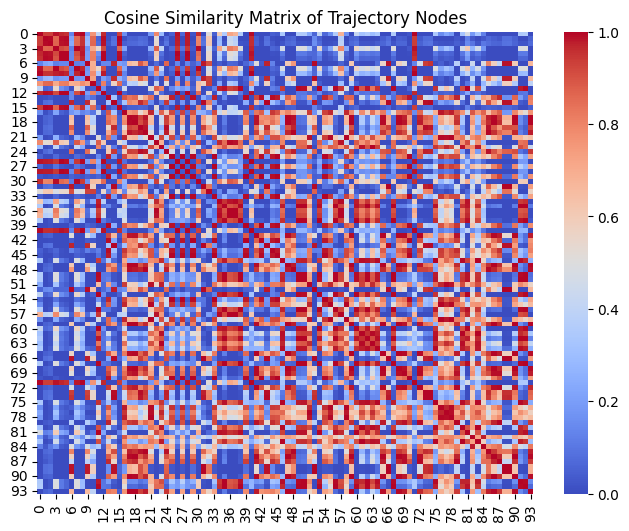

In [5]:
tra_graph = model.graphconvLayer.nodeEncoder(raw_tra_graph.clone())
det_graph = model.graphconvLayer.nodeEncoder(raw_det_graph.clone())

import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

#---------------------------------#
#  轨迹图
#---------------------------------#


node_embed = tra_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of Trajectory Nodes")

# 显示图像
plt.show()

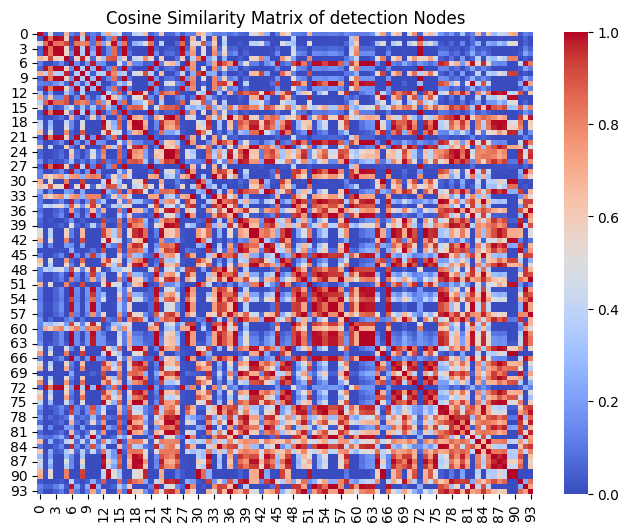

In [6]:
node_embed = det_graph.x
cos_sim_matrix = F.cosine_similarity(node_embed.unsqueeze(0), node_embed.unsqueeze(1), dim=2)
plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(cos_sim_matrix.detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("Cosine Similarity Matrix of detection Nodes")

# 显示图像
plt.show()

## 1.3 经过EdgeEncoder  完成图的构建之后，可视化图

In [7]:
tra_graph

Data(x=[94, 32], location_info=[94, 8])

In [8]:
tra_graph = model.graphconvLayer.edgeEncoder(tra_graph,cfg.K_NEIGHBOR)
det_graph = model.graphconvLayer.edgeEncoder(det_graph,cfg.K_NEIGHBOR)

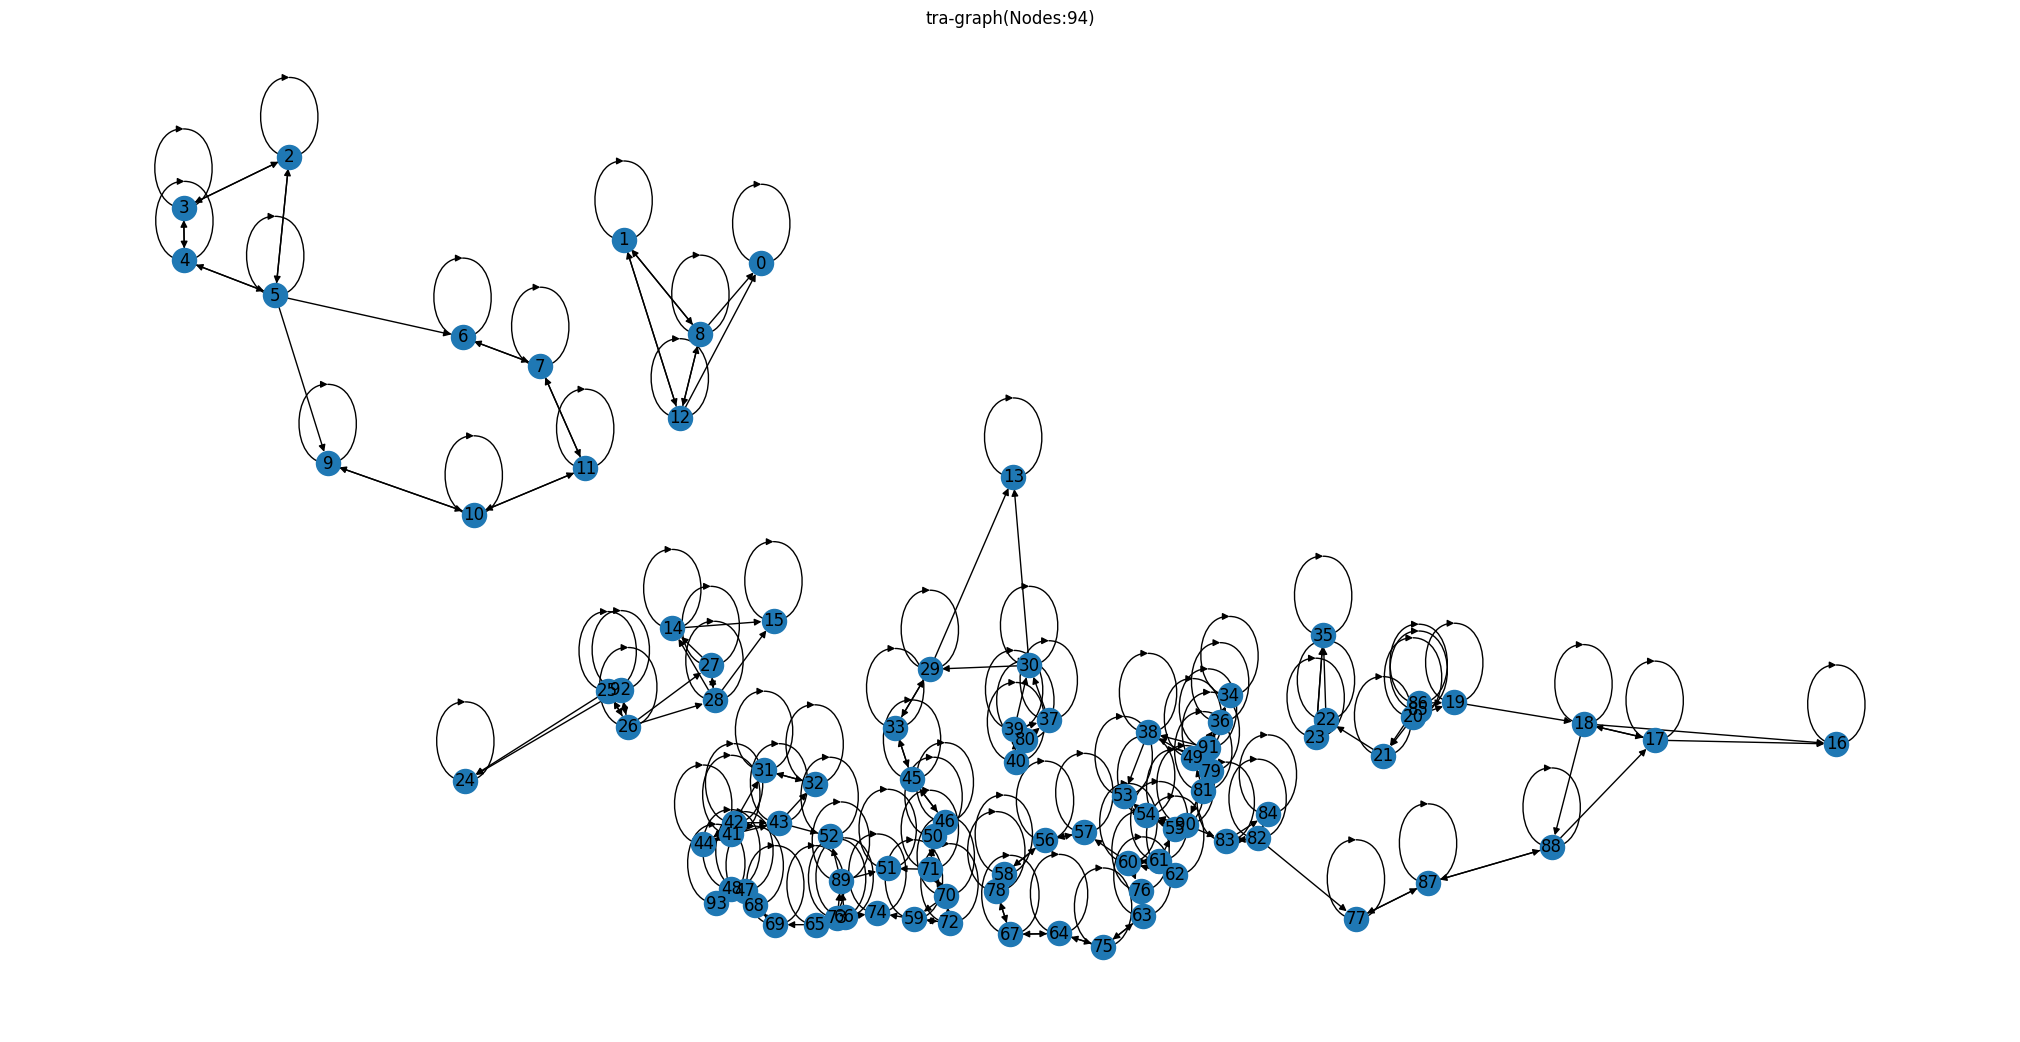

In [9]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
pos_dict = {}
for idx , pos in enumerate(tra_graph.location_info[:,:2]):
    pos_dict[idx] = pos.numpy()
G_tra = to_networkx(tra_graph, to_undirected=False)
plt.figure(figsize=(20, 10))
nx.draw(G_tra,pos=pos_dict,with_labels=True)
plt.title(f'tra-graph(Nodes:{tra_graph.num_nodes})')
plt.show()

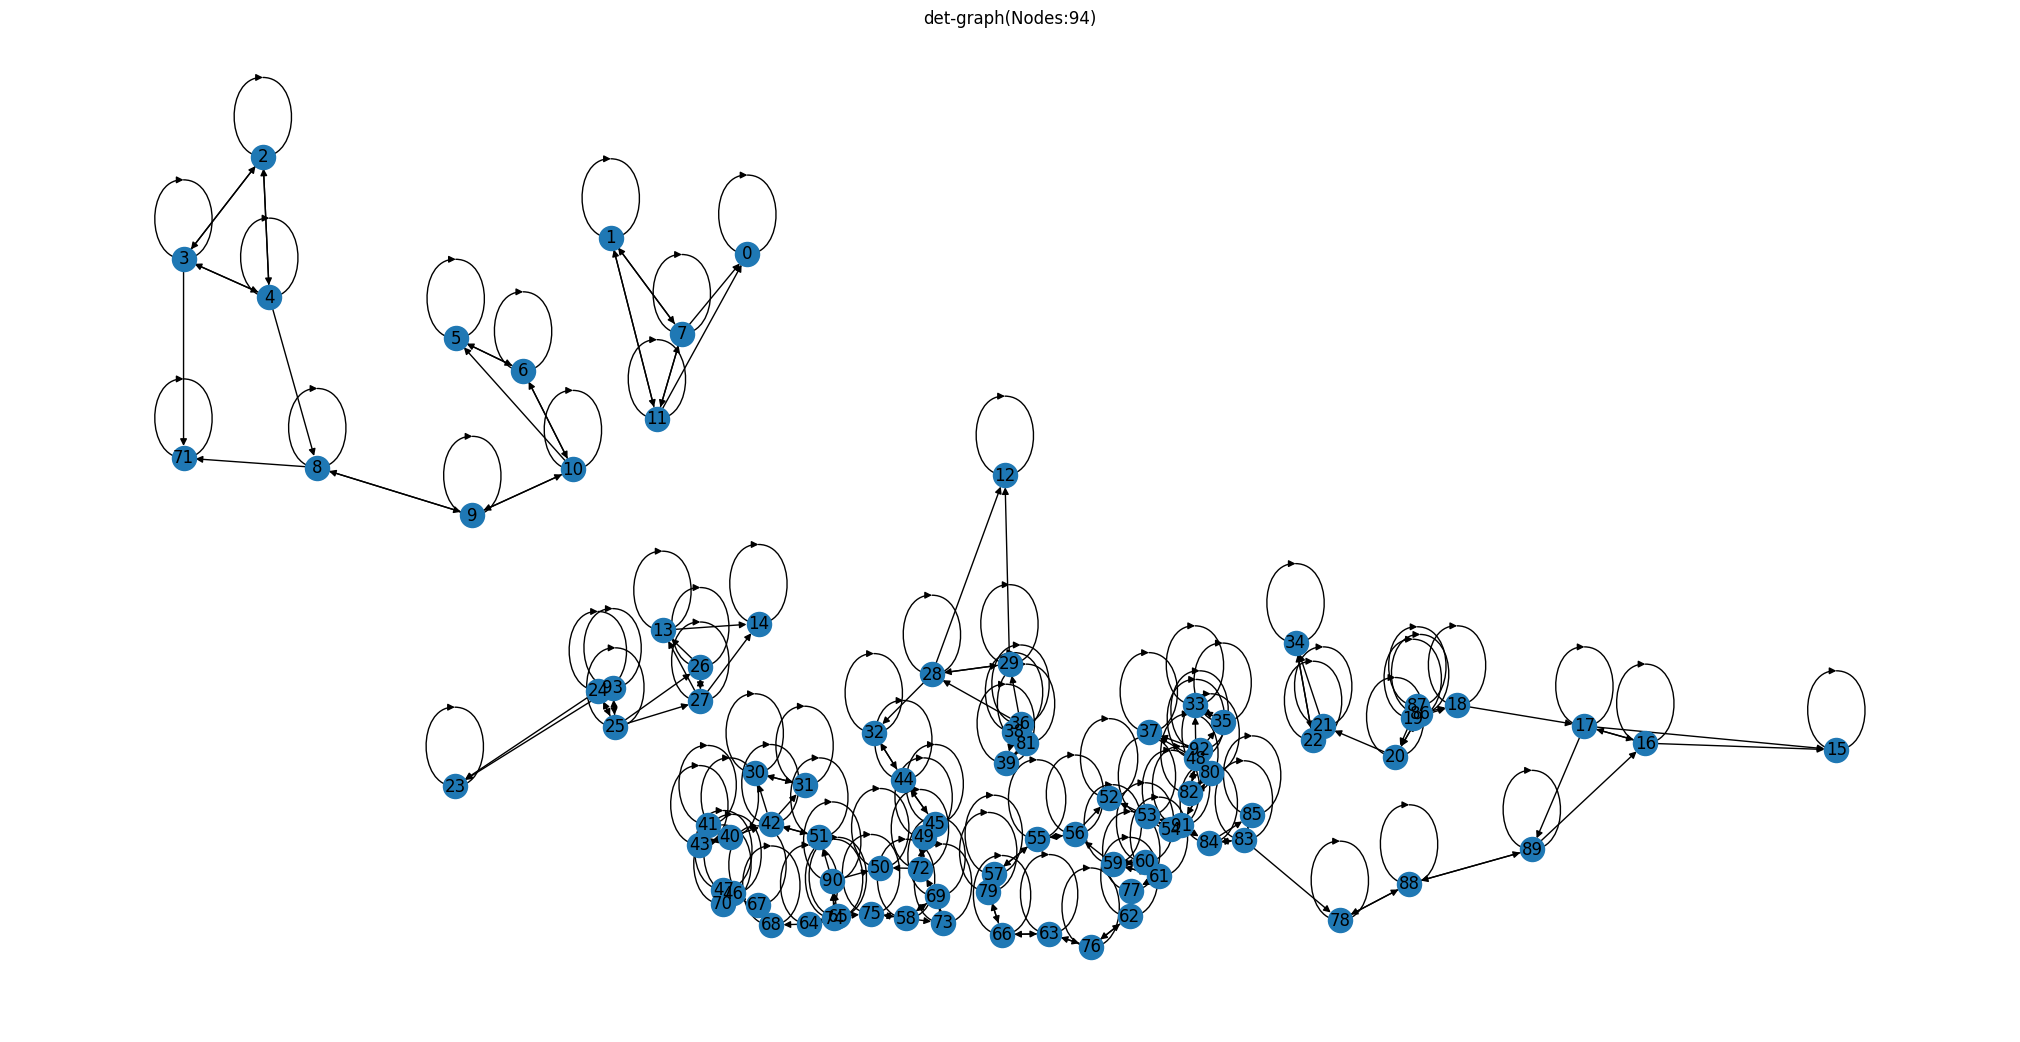

In [10]:
pos_dict = {}
for idx , pos in enumerate(det_graph.location_info[:,:2]):
    pos_dict[idx] = pos.numpy()

G_det = to_networkx(det_graph, to_undirected=False)
plt.figure(figsize=(20, 10))
nx.draw(G_det,with_labels=True,pos=pos_dict)
plt.title(f'det-graph(Nodes:{det_graph.num_nodes})')
plt.show()

In [11]:
det_graph,tra_graph

(Data(x=[94, 32], location_info=[94, 8], edge_index=[2, 282], edge_attr=[282, 18]),
 Data(x=[94, 32], location_info=[94, 8], edge_index=[2, 282], edge_attr=[282, 18]))

## 1.4  真值矩阵可视化

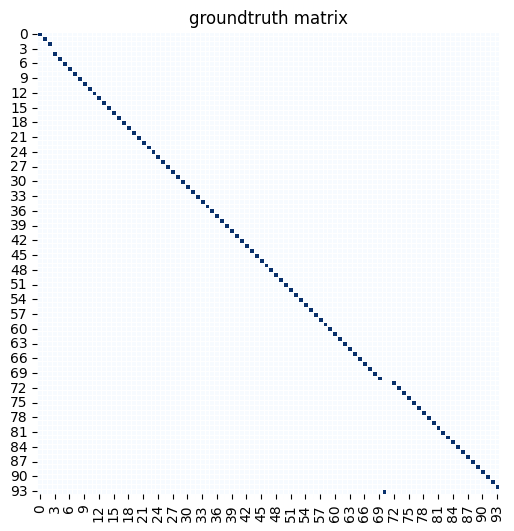

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F 

plt.figure(figsize=(8, 6))  # 设置热图大小
# sns.heatmap(cos_sim_matrix.detach().numpy(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
sns.heatmap(gt_matrix, annot=False, cmap='Blues', cbar=False, linewidths=0.5, square=True)

# 添加标题
plt.title("groundtruth matrix")

# 显示图像
plt.show()

## 1.5 graphconv可视化

In [13]:
#---------------------------------#
#  tra-graph first
#---------------------------------#
node_embedding = tra_graph.x
edge_embedding = tra_graph.edge_attr
edge_index     = tra_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_tra= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

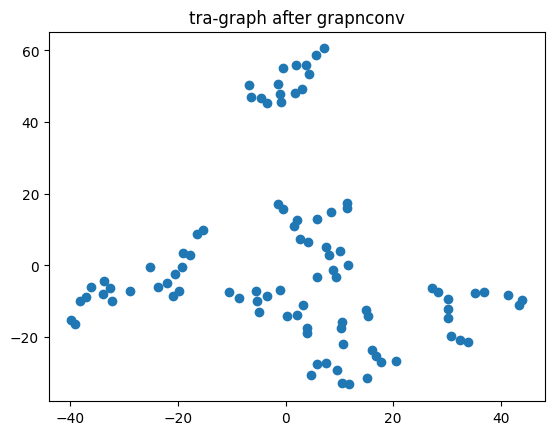

In [14]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_tra.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('tra-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


In [15]:
#---------------------------------#
#  det-graph first
#---------------------------------#
node_embedding = det_graph.x
edge_embedding = det_graph.edge_attr
edge_index     = det_graph.edge_index

node_embedding_sg1 = model.graphconvLayer.sg1Func(node_embedding,edge_index,edge_embedding)      # torch.Size([32, 32])
node_embedding_sg2 = model.graphconvLayer.sg2Func(node_embedding_sg1,edge_index,edge_embedding)  # torch.Size([32, 64])
node_embedding_sg3 = model.graphconvLayer.sg3Func(node_embedding_sg2,edge_index,edge_embedding)  # torch.Size([32, 96])


node_embedding_dg1 = model.graphconvLayer.dg1Func(node_embedding_sg1,cfg.K_NEIGHBOR)  # torch.Size([32,64])
node_embedding_dg2 = model.graphconvLayer.dg2Func(node_embedding_dg1,cfg.K_NEIGHBOR)  # torch.Size([32, 96])


node_embedding_cat1  = torch.cat([node_embedding_sg1,node_embedding_dg1,node_embedding_dg2,
                                    node_embedding_sg2,node_embedding_sg3],dim=1)     # torch.Size([32, 352])
node_embedding_fuse1 = model.graphconvLayer.fuse1Func(node_embedding_cat1)  # torch.Size([32, 1024])
node_embedding_cat2  = torch.cat([node_embedding_fuse1,node_embedding_cat1],dim=1)  # torch.Size([32, 1376])
node_embedding_output_det= model.graphconvLayer.fuse2Func(node_embedding_cat2)  # torch.Size([32, 128])

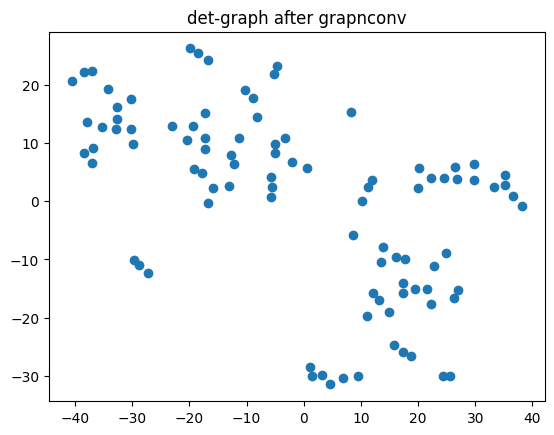

In [16]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 假设 node_embedding_output 是你的嵌入向量
embeddings = node_embedding_output_det.cpu().detach().numpy()

# 使用 t-SNE 进行降维
tsne = TSNE(n_components=2, random_state=0,perplexity=5)
embeddings_2d = tsne.fit_transform(embeddings)
plt.title('det-graph after grapnconv')
# 绘制嵌入向量
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1])
plt.show()


## 1.6 匹配矩阵可视化

In [37]:
corr = torch.mm(node_embedding_output_tra,node_embedding_output_det.transpose(1,0))
n1   = torch.norm(node_embedding_output_tra,dim=-1,keepdim=True)
n2   = torch.norm(node_embedding_output_det,dim=-1,keepdim=True)
cost = - corr / torch.mm(n1,n2.transpose(1,0))  

# 2. Prepare the augmented cost matrix for Sinkhorn
m , n = cost.shape
bins0 = model.alpha.expand(m, 1)
bins1 = model.alpha.expand(1, n)
alpha = model.alpha.expand(1, 1)
couplings = torch.cat([torch.cat([cost,bins0],dim=-1),
                        torch.cat([bins1,alpha],dim=-1)],dim=0)
# # norm  = 1 / (m+n)  
a_aug = torch.full((m+1,),1,dtype=torch.float32) 
b_aug = torch.full((n+1,),1,dtype=torch.float32) 
# a = torch.full((m,),0.95,dtype=torch.float32) 
# b = torch.full((n,),0.95,dtype=torch.float32) 
# a_aug[-1] = 0.95
# b_aug[-1] = 0.95

# pred_mtx = self.sinkhornLayer(couplings,a_aug,b_aug,
#                             self.sinkhorn_iters,torch.exp(self.eplison) + 0.03)


# to original possibility space 
pred_mtx = model.sinkhornLayer(couplings,a_aug,b_aug,
                            #   lambd_sink = torch.exp(self.eplison) + 0.03) * (m + n)
                                lambd_sink = torch.exp(model.eplison) + 0.03)

Text(0.5, 1.0, 'affinity matrix')

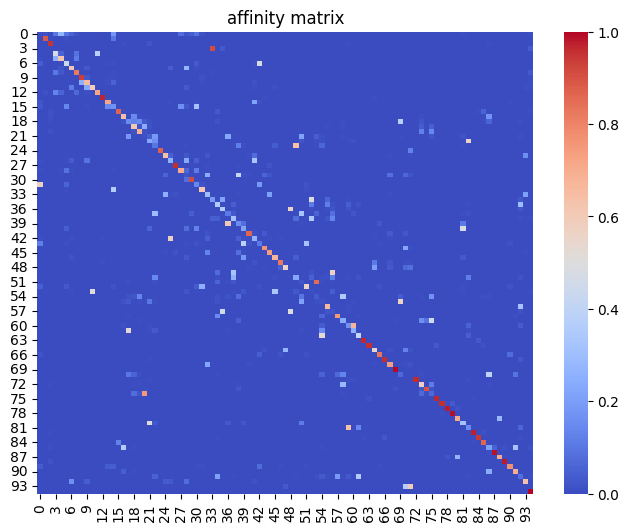

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(pred_mtx[:,:].detach().numpy(), cmap='coolwarm', cbar=True)

# 添加标题
plt.title("affinity matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

Text(0.5, 1.0, 'assignment matrix')

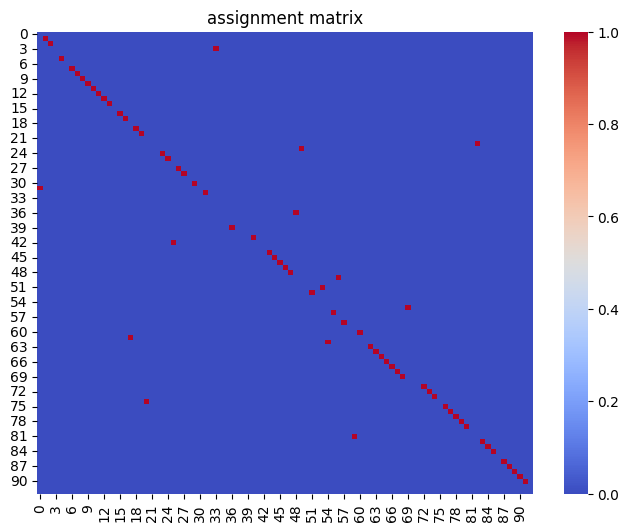

In [39]:
from models.graphToolkit import hungarian

match_mtx,match_idx,unmatch_tra,unmatch_det = hungarian(pred_mtx.detach(),0.5)

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))  # 设置热图大小
sns.heatmap(match_mtx[:-1,:-1], cmap='coolwarm', cbar=True)

# 添加标题
plt.title("assignment matrix")

# torch.sum(pred_mtx, dim=1),torch.sum(pred_mtx, dim=0),

In [ ]:
import numpy as np 
TP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 1))
FP = np.sum(np.logical_and(match_mtx == 1, gt_matrix.numpy() == 0))
FN = np.sum(np.logical_and(match_mtx == 0, gt_matrix.numpy() == 1))

# Precision
precision = TP / (TP + FP) if (TP + FP) > 0 else 0

# Recall
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
f1_score

0.6625766871165644

# 2. 假如用这个网络来分辨出跟踪的同一个目标，进行可视化

In [31]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#---------------------------------#
#  load  configs and checkpoint 
#---------------------------------#
import torch
from configs.config import get_config
from models.graphModel import GraphModel
from utils.graphDataset import GraphDataset
cfg = get_config()
model = GraphModel(cfg)
# test_dataset = GraphDataset(cfg,'Train',True)
# checkpoint = torch.load(r'experiments\checkpoints\latest.pth')
checkpoint = torch.load(r'experiments\checkpoints\bestScore(1.0)_epoch(86).pth')
model.load_state_dict(checkpoint["model"], strict=False)

<All keys matched successfully>

# 3. 统计 在不同帧率下，同一目标移动的像素均值（包括 移动视角与静止视角）

In [1]:
#---------------------------------#
#  data - whole dataset [MOT17,MOT20,DanceTrack]
#---------------------------------#

import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

lifespan = 10
dataset_type = {
    'MOT17': ['train'],
    'MOT20': ['train'],
    'DanceTrack': ['train','val']
}
# output_file = os.path.join(,'avgMovement.xlsx')
output_folder = os.path.join('experiments','statisticalData','avgMovement',f'windowSize[{lifespan}]')
os.makedirs(output_folder,exist_ok=True)
output_result = {}
maxvalue_list = []
maxvalue_seq = []

def calculate_average_movement(df, lifespan):
    results = []

    for id_, group in df.groupby('id'):
        # 获取当前目标的中心点坐标
        centers = group[['frame', 'center_x', 'center_y']].reset_index(drop=True)
        n_frames = len(centers)

        # 计算每个lifespan范围内的均值
        for start_frame in range(1, n_frames - lifespan + 1):
            end_frame = start_frame + lifespan - 1
            sub_group = centers[(centers['frame'] >= start_frame) & (centers['frame'] <= end_frame)]

            # 计算x, y坐标的平均移动距离
            displacements = np.sqrt(
                (sub_group['center_x'].diff().iloc[1:].values ** 2) + (sub_group['center_y'].diff().iloc[1:].values ** 2)
            )
            avg_displacement = displacements.mean() if len(displacements) > 0 else 0
            results.append({'id': id_, 'frame_range': f'{start_frame}-{end_frame}', 'avg_displacement': avg_displacement})

    return pd.DataFrame(results)

for dataset in dataset_type.keys():
    for sub_folder in dataset_type[dataset]:
        sub_folder_path = os.path.join('datasets',dataset,sub_folder)
        maxvalue_seq = []
        for seq in os.listdir(sub_folder_path):
            if not os.path.isdir(os.path.join(sub_folder_path,seq)):
                 continue
            gt_path   = os.path.join(sub_folder_path,seq,'gt','gt.txt')
            info_path = os.path.join(sub_folder_path,seq,'seqinfo.ini')
            with open(info_path,'r') as f:
                lines_split = [ l.split('=') for l in f.read().splitlines()[1:]]
                info_dict  = dict(s for s in lines_split if isinstance(s,list) and len(s) == 2)
            print(f"seq[{seq}] info: framerate[{info_dict['frameRate']}], height[{info_dict['imHeight']}], width[{info_dict['imWidth']}]")
            data = np.loadtxt(gt_path,delimiter=',')
            df = pd.DataFrame(data, columns=['frame', 'id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'ignore1', 'obj_type', 'ignore3'])
            df = df[df['obj_type'].isin([1,2,7])]
            df['center_x'] = df['bb_left'] + df['bb_width']  / 2
            df['center_y'] = df['bb_top']  + df['bb_height'] / 2
            df = df.sort_values(by=['id', 'frame'])

            result = calculate_average_movement(df, lifespan)

            output_result[seq] = result[result['avg_displacement'] != 0]
            meanvalue = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean().mean()
            maxvalue  = result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].max().max()
            maxvalue_seq.append(maxvalue)
            maxvalue_list.append(maxvalue)
            print(f"seq[{seq}] mean movement:[{meanvalue:.4f}], max movement:[{maxvalue:.4f}] ")
    #         break
        # break
    # break
        # 绘制当前序列的最大移动距离柱状图
        plt.figure(figsize=(10, 6))
        mean_value = np.mean(maxvalue_seq)
        plt.bar(range(len(maxvalue_seq)), maxvalue_seq, color='blue',label='Max Movement')
        for i, v in enumerate(maxvalue_seq):
            plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        plt.axhline(y=mean_value, color='r', linestyle='--',label=f'mean:{mean_value:.2f}') 
        # plt.text(len(maxvalue_seq) - 1, mean_value, f'Mean: {mean_value:.2f}', ha='right', va='bottom')  # 标注均值
        # plt.xlabel('Sequence')
        plt.legend()
        plt.ylabel('Max Movement')
        plt.title(f'Max Movement for Sequence {dataset}({sub_folder}) || WindowSize {lifespan}')
        plt.xticks(range(len(maxvalue_seq)), [f'Seq {i}' for i in range(1, len(maxvalue_seq) + 1)])
        plt.savefig(os.path.join(output_folder,f'maxMovement_{dataset}({sub_folder})-Window_{lifespan}.png'))
        plt.close()
plt.figure(figsize=(10, 6))
mean_value = np.mean(maxvalue_list)
plt.bar(range(len(maxvalue_list)), maxvalue_list, color='green',label='Max Movement')
for i, v in enumerate(maxvalue_list):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
plt.axhline(y=mean_value, color='r', linestyle='--',label=f'mean:{mean_value:.2f}') 
# plt.text(len(maxvalue_list) - 1, mean_value, f'Mean: {mean_value:.2f}', ha='right', va='bottom')  # 标注均值
# plt.xlabel('Sequence')
plt.legend()
plt.ylabel('Max Movement')
plt.title('Max Movement for All Sequences || WindowSize {lifespan}')
plt.xticks(range(len(maxvalue_list)), [f'Seq {i}' for i in range(1, len(maxvalue_list) + 1)])
plt.savefig(os.path.join(output_folder,f'maxMovement_all-Window_{lifespan}.png'))
plt.close()


# so large file that cannot save 
# output_df = pd.concat(output_result.values(), keys=output_result.keys())
# output_df.to_excel(output_file)
          

seq[MOT17-02] info: framerate[30], height[1080], width[1920]
seq[MOT17-02] mean movement:[1.4877], max movement:[16.0702] 
seq[MOT17-04] info: framerate[30], height[1080], width[1920]
seq[MOT17-04] mean movement:[1.1680], max movement:[6.9030] 
seq[MOT17-05] info: framerate[14], height[480], width[640]
seq[MOT17-05] mean movement:[3.7638], max movement:[25.0632] 
seq[MOT17-09] info: framerate[30], height[1080], width[1920]
seq[MOT17-09] mean movement:[8.5315], max movement:[52.1891] 
seq[MOT17-10] info: framerate[30], height[1080], width[1920]
seq[MOT17-10] mean movement:[5.7407], max movement:[27.2474] 
seq[MOT17-11] info: framerate[30], height[1080], width[1920]
seq[MOT17-11] mean movement:[5.8848], max movement:[24.1041] 
seq[MOT17-13] info: framerate[25], height[1080], width[1920]
seq[MOT17-13] mean movement:[5.4987], max movement:[18.8075] 
seq[MOT20-01] info: framerate[25], height[1080], width[1920]
seq[MOT20-01] mean movement:[2.5048], max movement:[9.5901] 
seq[MOT20-02] info: 

In [19]:
# 计算每个 id 的非零值均值
result[result['avg_displacement'] != 0].groupby('id')['avg_displacement'].mean()

# 打印每个 id 的非零均值



id
2.0     9.705236
3.0     2.459258
8.0     9.420242
9.0     0.293786
10.0    0.408170
11.0    1.932565
12.0    3.318878
13.0    1.722288
14.0    0.719138
15.0    0.385521
17.0    0.378842
18.0    0.463388
19.0    3.075961
20.0    3.966158
21.0    2.689769
22.0    2.419442
23.0    2.438510
26.0    0.423005
27.0    0.278720
28.0    0.302334
29.0    0.378220
30.0    0.063166
31.0    0.312433
36.0    2.671455
37.0    3.564709
38.0    8.907924
39.0    1.633351
40.0    1.465651
41.0    1.374012
42.0    0.992079
43.0    0.304192
44.0    0.800684
45.0    0.137405
46.0    0.125785
47.0    0.135944
54.0    0.201556
57.0    0.145977
58.0    0.256257
59.0    0.203430
60.0    0.163480
61.0    0.186484
62.0    0.222062
65.0    0.092523
66.0    0.116724
67.0    0.561806
68.0    0.192304
69.0    0.214311
70.0    0.606488
72.0    0.994229
73.0    0.559769
Name: avg_displacement, dtype: float64